## Projeto de Clusterização - HELP International (Notebook Final)

Objetivo: usar dados socioeconômicos e de saúde para agrupar países e identificar o grupo em extrema necessidade de ajuda humanitária.

Este notebook está organizado para atender às especificações do trabalho:
- Parte 1: Infraestrutura (ambiente local, venv, bibliotecas, requirements, evidências).
- Parte 2: Escolha de base de dados e Análise Exploratória (EDA).
- Parte 3: Clusterização (K-Médias e Hierárquica), interpretação e comparação.
- Parte 4: Escolha de algoritmos (passos do K-médias, variante com medóide, discussão de outliers e DBSCAN).

Observações:
- Rode as células na ordem em que aparecem.
- Caso o download via Kaggle API não funcione, coloque o arquivo localmente em `data/` e rode novamente.
- Para submissão, gere `requirements.txt` com pip freeze (célula ao final) e publique no Git.


### Parte 1: Infraestrutura (checagens + evidências)
- Verificar versão do Python (3.9+).
- Confirmar se está em um ambiente virtual (Virtualenv/Conda).
- Mostrar caminhos do Python e do pip.
- Tirar um printscreen desta saída para anexar ao relatório.

Evidências de ambiente e execução (montagem consolidada):
![Evidências de ambiente, versões, gráficos gerados e detalhes de execução](images/evidencias.png)

Passos para reproduzir o ambiente e exportar o HTML (macOS/Linux):
```bash
python3 -m venv clusterizacao
source clusterizacao/bin/activate
pip install -r requirements.txt
jupyter nbconvert --to html Projeto_Clusterizacao_executado.ipynb --output Projeto_Clusterizacao_executado.html
```
Observação: no Windows, use `clusterizacao\Scripts\activate` para ativar o venv.


### Checklist de Execução (Run All)
Antes de gerar o PDF final, siga este roteiro simples:
- Reinicie o kernel e execute todas as células sequencialmente.
- Valide a evidência de ambiente na Parte 1.
- Confirme que o dataset foi carregado (shape e colunas).
- Gere os gráficos de faixa dinâmica (boxplots e histogramas).
- Padronize variáveis numéricas (StandardScaler).
- Rode K-Means (k=3), identifique medóides e visualize em PCA.
- Rode Hierárquico (Ward) e analise o dendrograma.
- Revise a interpretação textual dos resultados (célula automática + comentários).
- Gere o requirements.txt e publique no Git.
- Exporte o HTML e gere o PDF com o nome exigido para o Moodle.


In [1]:
import sys, os, shutil

print('Python version:', sys.version)
print('Python executable:', sys.executable)

# Detecta se venv está ativo (Virtualenv/Conda)
is_venv = sys.prefix != getattr(sys, 'base_prefix', sys.prefix)
print('Ambiente virtual ativo:', is_venv)

# Caminhos úteis
print('pip path:', shutil.which('pip'))
print('python -m pip path:', shutil.which('python'))

# Dica: tire um print desta célula para evidência de execução local e venv.


Python version: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 11:23:37) [Clang 14.0.6 ]
Python executable: /Users/fabiofigueiredo/Documents/Pós Infnet/Clusterização/PD/PD Fabio/clusterizacao/bin/python3
Ambiente virtual ativo: True
pip path: /Users/fabiofigueiredo/Documents/Pós Infnet/Clusterização/PD/PD Fabio/clusterizacao/bin/pip
python -m pip path: /Users/fabiofigueiredo/Documents/Pós Infnet/Clusterização/PD/PD Fabio/clusterizacao/bin/python


### Imports e configuração geral
- Se alguma biblioteca não estiver instalada, instale no seu venv: `pip install <pacote>`.
- Pacotes necessários: numpy, pandas, scikit-learn, scipy, matplotlib, seaborn, kaggle (para download).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# Diretório para imagens dos gráficos (para exportação HTML com alt text)
IMAGES_DIR = Path('images')
IMAGES_DIR.mkdir(parents=True, exist_ok=True)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage, dendrogram

sns.set(style='whitegrid', context='notebook')
np.random.seed(42)

DATA_DIR = Path('data')
DATA_DIR.mkdir(exist_ok=True)

print('Ambiente OK: imports carregados.')


Ambiente OK: imports carregados.


### Parte 2: Baixar/Carregar base de dados (Kaggle)
Base: https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data

Se a API do Kaggle estiver configurada (arquivo `~/.kaggle/kaggle.json`), a célula abaixo tentará baixar e extrair os dados. Como fallback, você pode colocar manualmente o arquivo `Country-data.csv` dentro de `data/` e pular o download.


In [3]:
import subprocess

def ensure_dataset(dataset='rohan0301/unsupervised-learning-on-country-data', dest_dir=DATA_DIR):
    # Procura arquivo localmente (case-insensitive)
    candidates = list(dest_dir.glob('Country-data.csv')) + list(dest_dir.glob('country-data.csv'))
    if candidates:
        print('Encontrado arquivo local:', candidates[0])
        return candidates[0]

    kaggle_json = Path.home() / '.kaggle' / 'kaggle.json'
    kaggle_cli = shutil.which('kaggle')

    if kaggle_cli and kaggle_json.exists():
        print('Tentando baixar via Kaggle CLI...')
        try:
            # Baixa e descompacta no diretório data/
            cmd = ['kaggle', 'datasets', 'download', '-d', dataset, '-p', str(dest_dir), '--unzip']
            res = subprocess.run(cmd, capture_output=True, text=True)
            print('stdout:', res.stdout[:500])
            print('stderr:', res.stderr[:500])
        except Exception as e:
            print('Falha no download via Kaggle:', e)

    # Checa novamente após tentativa de download
    candidates = list(dest_dir.glob('Country-data.csv')) + list(dest_dir.glob('country-data.csv'))
    if candidates:
        print('Arquivo disponível em:', candidates[0])
        return candidates[0]

    raise FileNotFoundError("Dataset não encontrado. Coloque 'Country-data.csv' em data/ e rode novamente.")

dataset_path = ensure_dataset()
dataset_path


Encontrado arquivo local: data/Country-data.csv


PosixPath('data/Country-data.csv')

In [4]:
# Carrega o dataset
df = pd.read_csv(dataset_path)
print('Shape:', df.shape)
print('Colunas:', list(df.columns))

# Conferência de nomes e tipos
df.head()


Shape: (167, 10)
Colunas: ['country', 'child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [5]:
# Quantos países existem no dataset?
col_country = 'country' if 'country' in df.columns else [c for c in df.columns if c.lower()=='country'][0]
n_paises = df[col_country].nunique()
print(f'Número de países no dataset: {n_paises}')

# Identificação de variáveis numéricas
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('Variáveis numéricas:', num_cols)

# Estatísticas básicas e faixa dinâmica
stats = df[num_cols].describe().T
stats[['min','max','mean','std']]


Número de países no dataset: 167
Variáveis numéricas: ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']


,min,max,mean,std
child_mort,2.6000,208.00,38.270060,40.328931
exports,0.1090,200.00,41.108976,27.412010
health,1.8100,17.90,6.815689,2.746837
imports,0.0659,174.00,46.890215,24.209589
income,609.0000,125000.00,17144.688623,19278.067698
inflation,-4.2100,104.00,7.781832,10.570704
life_expec,32.1000,82.80,70.555689,8.893172
total_fer,1.1500,7.49,2.947964,1.513848
gdpp,231.0000,105000.00,12964.155689,18328.704809


#### Gráficos da faixa dinâmica das variáveis (antes da clusterização)
Observação: Muitos gráficos em escala diferente podem dificultar a visualização; por isso é recomendado padronizar os dados antes da clusterização.


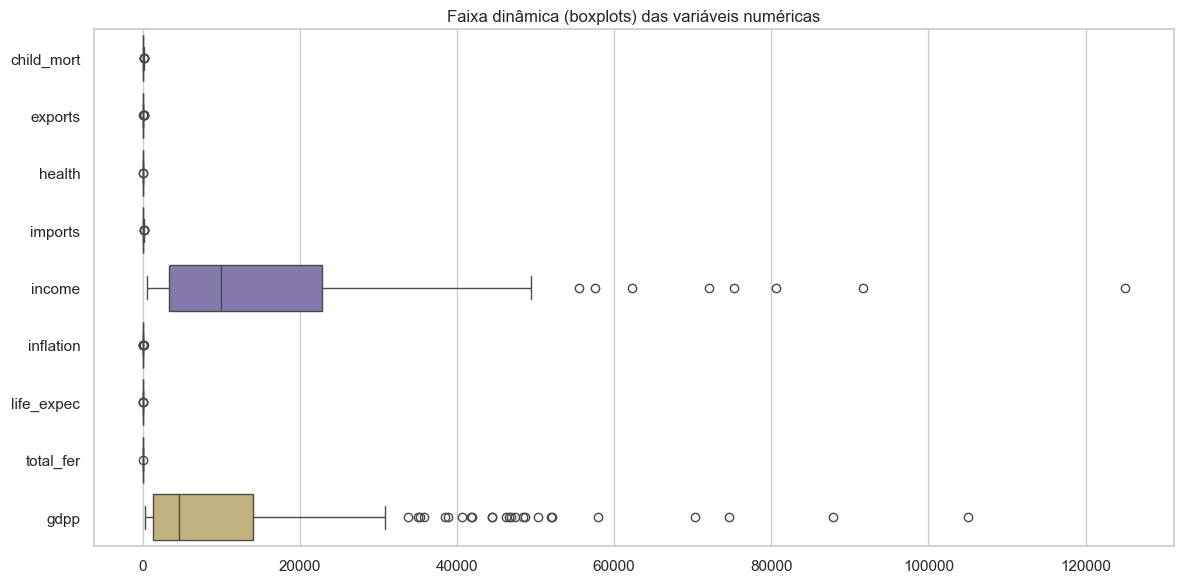

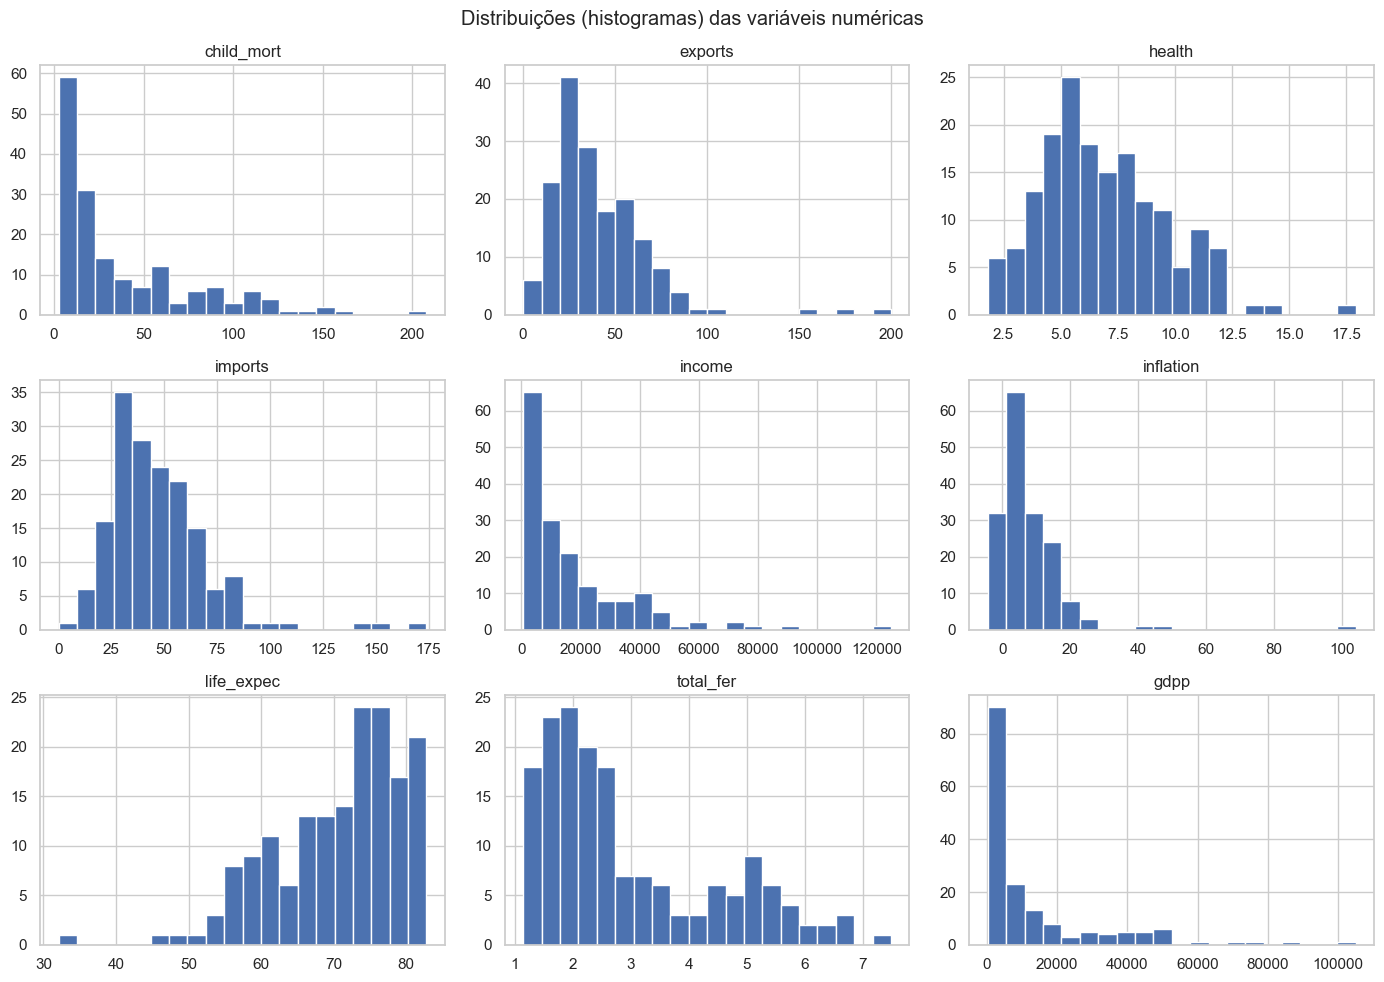

Antes da clusterização, recomenda-se padronizar as variáveis (StandardScaler).


In [6]:
# Boxplots por variável
fig_box = plt.figure(figsize=(12, 6))
sns.boxplot(data=df[num_cols], orient='h')
plt.title('Faixa dinâmica (boxplots) das variáveis numéricas')
plt.tight_layout()
fig_box.savefig(str(IMAGES_DIR / 'boxplots_variaveis_numericas.png'), dpi=150, bbox_inches='tight')
plt.close(fig_box)

# Histograma por variável
df[num_cols].hist(figsize=(14, 10), bins=20)
plt.suptitle('Distribuições (histogramas) das variáveis numéricas')
fig_hist = plt.gcf()
fig_hist.tight_layout()
fig_hist.savefig(str(IMAGES_DIR / 'histogramas_variaveis_numericas.png'), dpi=150, bbox_inches='tight')
plt.close(fig_hist)

print('Antes da clusterização, recomenda-se padronizar as variáveis (StandardScaler).')


### Pré-processamento
- Tratar ausentes (se houver).
- Padronizar variáveis numéricas.


![Boxplots das variáveis numéricas (escala original; whiskers e outliers visíveis)](images/boxplots_variaveis_numericas.png)
Legenda: Boxplots por variável numérica; útil para detectar outliers e amplitude.
- Interpretação: valores muito fora da caixa (pontos) são potenciais outliers que podem puxar centróides do K-Means.
- Consideração: se houver forte assimetria/outliers, avaliar RobustScaler ou Winsorização antes da clusterização.

![Histogramas das variáveis numéricas (bins=20; distribuição por variável)](images/histogramas_variaveis_numericas.png)
Legenda: Histogramas por variável numérica; verifique assimetria e multimodalidade.
- Interpretação: caudas longas (skew) ou múltiplos picos (multimodalidade) podem afetar métricas de distância.
- Consideração: padronização (StandardScaler) já aplicada adiante; transforme apenas se necessário (ex.: log para estritamente positivas).


In [7]:
# Tratamento simples de ausentes: imputação por mediana (se houver NA)
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[num_cols])
df_scaled_features = pd.DataFrame(X_scaled, columns=num_cols)

print('Pré-processamento OK: dados padronizados gerados (df_scaled_features).')
df_scaled_features.head()


Pré-processamento OK: dados padronizados gerados (df_scaled_features).


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


### Parte 3: Clusterização - K-Médias (k=3)
- Ajustar KMeans em dados padronizados.
- Calcular centróides e medóides (país mais próximo ao centróide) por cluster.
- Visualizar no espaço PCA (2D).

Dados usados e variáveis-chave:
- `df_scaled_features`: dados padronizados gerados com `StandardScaler` a partir de `num_cols`.
- `labels_kmeans`: rótulos dos clusters atribuídos pelo KMeans.
- `df_kmeans['cluster_kmeans']`: coluna com o cluster de cada país (para agregações e interpretação).
- `perfil_clusters`: médias das variáveis por cluster (perfil socioeconômico/saúde típico).

Medóide por cluster (interpretação):
- Função calcula o país mais próximo do centróide no espaço padronizado (menor distância euclidiana).
- Útil para comunicação: um país representativo por cluster ajuda a explicar o perfil do grupo.

Considerações do K-Means:
- Assume agrupamentos aproximadamente esféricos/convexos e usa distância Euclidiana.
- Sensível a outliers e escala: por isso padronizamos previamente.
- `n_init=10`: múltiplas inicializações para reduzir risco de mínimo local.


In [8]:
# Ajuste de KMeans
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(df_scaled_features)

labels_kmeans = kmeans.labels_
df_kmeans = df.copy()
df_kmeans['cluster_kmeans'] = labels_kmeans

# Perfil dos clusters (médias das variáveis numéricas)
perfil_clusters = df_kmeans.groupby('cluster_kmeans')[num_cols].mean()
print('Perfil de médias por cluster (KMeans):')
perfil_clusters

# Função para medóides: país mais próximo ao centróide do cluster (no espaço padronizado)
def compute_medoids_from_kmeans(X_scaled_df, labels, centroids, countries):
    medoid_indices = {}
    medoid_countries = {}
    X = X_scaled_df.values
    for c in np.unique(labels):
        idx = np.where(labels == c)[0]
        Xc = X[idx]
        centroid = centroids[c]
        dists = np.linalg.norm(Xc - centroid, axis=1)
        local_min = np.argmin(dists)
        medoid_idx = idx[local_min]
        medoid_indices[c] = medoid_idx
        medoid_countries[c] = countries[medoid_idx]
    return medoid_indices, medoid_countries

countries = df[col_country].values
medoid_idx_map, medoid_country_map = compute_medoids_from_kmeans(
    df_scaled_features, labels_kmeans, kmeans.cluster_centers_, countries
)

print('Medóides por cluster (KMeans):')
for c in sorted(medoid_country_map.keys()):
    print(f'Cluster {c}:', medoid_country_map[c])


Perfil de médias por cluster (KMeans):
Medóides por cluster (KMeans):
Cluster 0: Iceland
Cluster 1: Guinea
Cluster 2: Jamaica


#### Visualização em 2D via PCA
Transformamos os dados padronizados e os centróides do KMeans para o espaço PCA (2 componentes).
- Cada eixo (PC1, PC2) é uma combinação linear das variáveis originais (após padronização).
- Pontos coloridos: países; o 'X' preto marca o centróide transformado do K-Means em 2D.
- Leitura: clusters bem separados em PCA sugerem boa discriminação; sobreposição indica proximidade entre grupos.
- Nota: PCA reduz dimensionalidade e pode perder variações pequenas; use apenas como visual de apoio.


/Users/fabiofigueiredo/Documents/Pós Infnet/Clusterização/PD/PD Fabio/clusterizacao/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


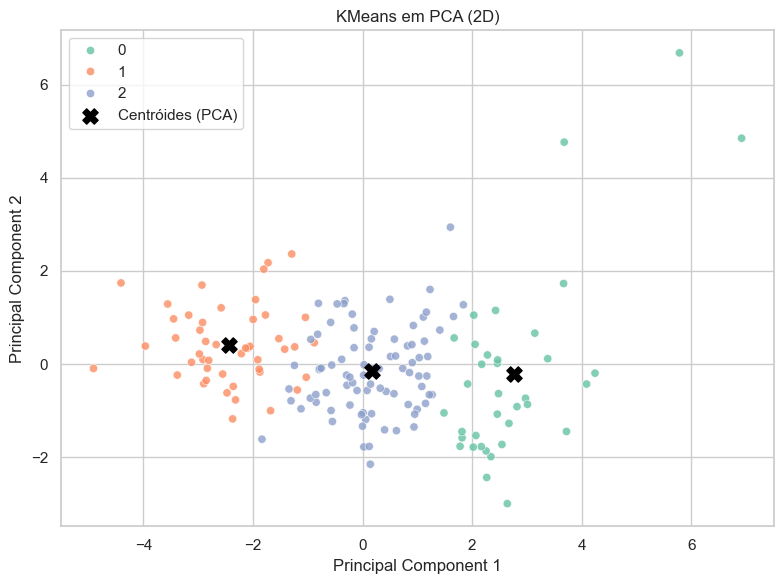

Centróides K-Means transformados para 2 componentes principais:
[[ 2.76977273 -0.21301421]
 [-2.43461995  0.41127566]
 [ 0.17518237 -0.13882672]]


In [9]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(df_scaled_features)
df_pca = pd.DataFrame(X_pca, columns=['Principal Component 1', 'Principal Component 2'])
df_pca['cluster_kmeans'] = labels_kmeans

centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='Principal Component 1', y='Principal Component 2', hue='cluster_kmeans', palette='Set2', alpha=0.8)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='black', s=120, marker='X', label='Centróides (PCA)')
plt.title('KMeans em PCA (2D)')
plt.legend()
plt.tight_layout()
fig_pca = plt.gcf()
fig_pca.savefig(str(IMAGES_DIR / 'pca_2d_clusters.png'), dpi=150, bbox_inches='tight')
plt.close(fig_pca)

print('Centróides K-Means transformados para 2 componentes principais:')
print(centroids_pca)


### Clusterização Hierárquica + Dendrograma
- Método: linkage='ward' minimiza a variância intracluster e usa distância euclidiana. Por isso, é essencial padronizar as variáveis (StandardScaler) antes de aplicar.
- Guia de leitura do dendrograma:
  - Altura representa a distância de fusão: junções altas indicam grupos mais distintos; junções baixas indicam subgrupos próximos.
  - O truncamento (p=5) mostra apenas os níveis superiores; se precisar ver todos os níveis e microgrupos, remova o truncamento.
  - A escolha de k pode ser feita por um corte horizontal onde haja um "gap" claro nas alturas. O número de ramos interceptados = quantidade de clusters.
- AgglomerativeClustering com k=3 é usado para comparar com KMeans e verificar a estabilidade dos grupos sob outro critério.
- Avaliação: utilize o índice de silhouette e a tabela de contingência (crosstab) KMeans vs Hierárquico para medir concordância e qualidade.
  - Silhouette ~0.25–0.35 indica separação moderada; valores maiores sugerem separação mais nítida.
  - No crosstab, valores altos na diagonal indicam forte concordância entre métodos; valores fora da diagonal indicam reagrupamentos.
- Diferenças esperadas entre KMeans e Hierárquico: sensibilidade a outliers, formas não esféricas dos clusters, e efeitos de inicialização (KMeans). Ward tende a favorecer grupos compactos.


![PCA 2D: pontos coloridos por cluster (KMeans) e X preto = centróide transformado](images/pca_2d_clusters.png)
Legenda: Redução para 2 componentes principais; separação aproximada dos clusters no plano.


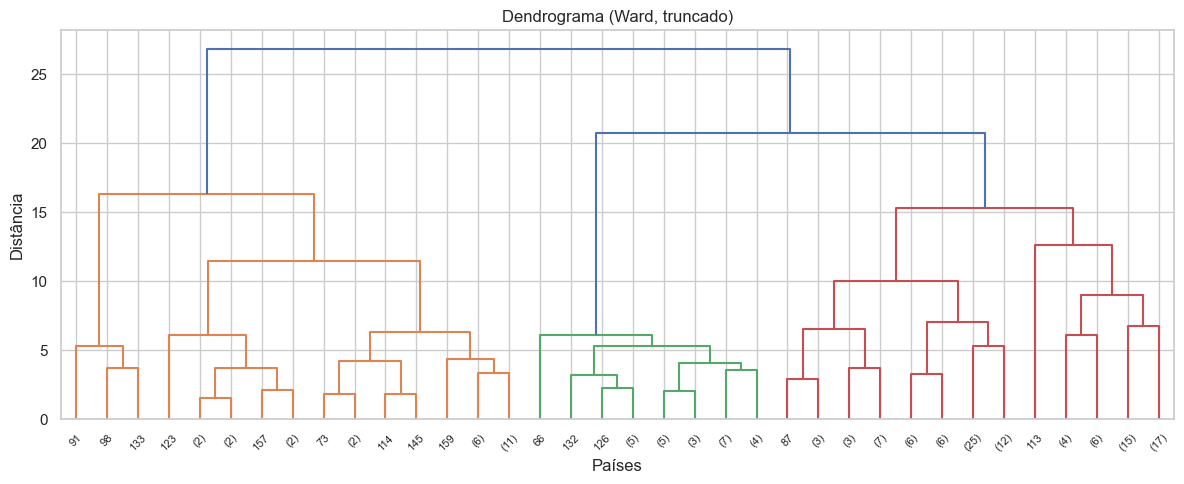

Crosstab KMeans vs Hierárquico:
Silhouette - KMeans: 0.283, Agglomerative: 0.246


In [10]:
# Dendrograma
Z = linkage(df_scaled_features, method='ward')
fig_den = plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Dendrograma (Ward, truncado)')
plt.xlabel('Países')
plt.ylabel('Distância')
plt.tight_layout()
fig_den.savefig(str(IMAGES_DIR / 'dendrograma_ward_truncado.png'), dpi=150, bbox_inches='tight')
plt.close(fig_den)

# Clusterização hierárquica com 3 grupos
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_agg = agg.fit_predict(df_scaled_features)
df_agg = df.copy()
df_agg['cluster_agg'] = labels_agg

# Comparação KMeans vs Agglomerative
ct = pd.crosstab(df_kmeans['cluster_kmeans'], df_agg['cluster_agg'])
print('Crosstab KMeans vs Hierárquico:')
ct

# Silhouette (apenas como indicação de qualidade)
sil_kmeans = silhouette_score(df_scaled_features, labels_kmeans)
sil_agg = silhouette_score(df_scaled_features, labels_agg)
print(f'Silhouette - KMeans: {sil_kmeans:.3f}, Agglomerative: {sil_agg:.3f}')


#### Interpretação dos Resultados
- K-Médias: descreva a distribuição das dimensões (médias por cluster) e o país que melhor representa cada grupo (medóide).
- Hierárquico: com base no dendrograma, descreva as fusões tardias (galhos mais altos) e o racional do corte em k≈3; destaque quais grupos parecem mais distintos e quais são subgrupos próximos.
- Qualidade e concordância: utilize silhouette e o crosstab (KMeans vs Hierárquico). Diagonal alta no crosstab = maior concordância; valores fora da diagonal indicam divergências a serem explicadas (formas de cluster, outliers, etc.).
- Compare os dois resultados: semelhanças, diferenças e possíveis razões (sensibilidade a inicialização, forma dos clusters, Ward favorece grupos compactos).

Use as tabelas e gráficos acima para sustentar a análise.


![Dendrograma Hierárquico (linkage=Ward; truncado nível p=5)](images/dendrograma_ward_truncado.png)
Leitura sugerida: faça um corte horizontal onde há maior "gap" nas alturas e conte os ramos interceptados (≈3), sinalizando k≈3.
Ramos que se unem em alturas maiores representam grupos mais distintos; junções baixas sugerem subgrupos com alta similaridade.
Observação: o truncamento (p=5) exibe os níveis superiores do dendrograma; para analisar níveis inferiores e microgrupos, gere a figura sem truncamento.


In [11]:
# Relatório automático de interpretação (KMeans vs Hierárquico)
# Usa variáveis já calculadas: df, df_kmeans, labels_kmeans, perfil_clusters, medoid_country_map, ct, sil_kmeans, sil_agg

analysis_lines = []
analysis_lines.append(f'Número de países no dataset: {n_paises}.')
dist = df_kmeans['cluster_kmeans'].value_counts().sort_index()
analysis_lines.append('Distribuição por cluster (KMeans): ' + ', '.join([f'{i}: {cnt}' for i, cnt in dist.items()]))

global_mean = df[num_cols].mean()
for c in sorted(perfil_clusters.index):
    dif = (perfil_clusters.loc[c] - global_mean)
    top_vars = dif.abs().sort_values(ascending=False).head(3).index.tolist()
    med = medoid_country_map.get(c, 'N/A')
    analysis_lines.append(
        f'Cluster {c}: medóide = {med}; variáveis mais distintivas (diferença vs média global): ' + ', '.join(top_vars) + '\n'
    )

analysis_lines.append(f'Silhouette (KMeans): {sil_kmeans:.3f}; Silhouette (Hierárquico): {sil_agg:.3f}.')
analysis_lines.append('Crosstab KMeans vs Hierárquico:\n' + ct.to_string())

for _line in analysis_lines:
    print(_line)

# Também devolve tabelas úteis para inspeção
perfil_clusters


Número de países no dataset: 167.
Distribuição por cluster (KMeans): 0: 36, 1: 47, 2: 84
Cluster 0: medóide = Iceland; variáveis mais distintivas (diferença vs média global): gdpp, income, child_mort

Cluster 1: medóide = Guinea; variáveis mais distintivas (diferença vs média global): income, gdpp, child_mort

Cluster 2: medóide = Jamaica; variáveis mais distintivas (diferença vs média global): gdpp, income, child_mort

Silhouette (KMeans): 0.283; Silhouette (Hierárquico): 0.246.
Crosstab KMeans vs Hierárquico:
cluster_agg      0   1   2
cluster_kmeans            
0               31   5   0
1                0  20  27
2                3  81   0


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster_kmeans,,,,,,,,,
0,5.000000,58.738889,8.807778,51.491667,45672.222222,2.671250,80.127778,1.752778,42494.444444
1,92.961702,29.151277,6.388511,42.323404,3942.404255,12.019681,59.187234,5.008085,1922.382979
2,21.927381,40.243917,6.200952,47.473404,12305.595238,7.600905,72.814286,2.307500,6486.452381


### Interpretação dos Resultados — K-Means

- Distribuição por cluster (K-Means): 0 = 36 países; 1 = 47; 2 = 84.\n- Qualidade: Silhouette — K-Means = 0,283; Hierárquico = 0,246 (separação moderada no K-Means).\n- Correspondência entre métodos (crosstab): Cluster 0 (K-Means) casa fortemente com Cluster 0 (Hierárquico); Cluster 2 (K-Means) casa majoritariamente com Cluster 1 (Hierárquico); Cluster 1 (K-Means) divide-se entre Hierárquico 1 e 2.

#### Cluster 0 — Países desenvolvidos
- Medóide (país representativo): Iceland (Islândia).
- Principais médias (ver tabela acima `perfil_clusters`):
  - child_mort: 5\n  - income: 45.672\n  - life_expec: 80,13 anos\n  - total_fer: 1,75\n  - inflation: 2,67%\n  - exports: 58,74% do PIB\n  - imports: 51,49% do PIB\n  - health: 8,81% do PIB\n  - gdpp: 42.494\n- Destaques: baixíssima mortalidade infantil, altíssima renda/PIB per capita e alta expectativa de vida; variáveis mais distintivas vs média global: `gdpp`, `income`, `child_mort`.

#### Cluster 1 — Países de baixa renda / alta vulnerabilidade
- Medóide: Guinea (Guiné).
- Principais médias:
  - child_mort: 92,96\n  - income: 3.942\n  - life_expec: 59,19 anos\n  - total_fer: 5,01\n  - inflation: 12,02%\n  - exports: 29,15% do PIB\n  - imports: 42,32% do PIB\n  - health: 6,39% do PIB\n  - gdpp: 1.922\n- Destaques: alta mortalidade infantil e fertilidade, baixa renda/PIB per capita e inflação elevada; grupo mais vulnerável socioeconomicamente. Distintivos vs média global: `child_mort`, `gdpp`, `income`.

#### Cluster 2 — Países em desenvolvimento / intermediários
- Medóide: Jamaica.
- Principais médias:
  - child_mort: 21,93\n  - income: 12.306\n  - life_expec: 72,81 anos\n  - total_fer: 2,31\n  - inflation: 7,60%\n  - exports: 40,24% do PIB\n  - imports: 47,47% do PIB\n  - health: 6,20% do PIB\n  - gdpp: 6.486\n- Destaques: valores intermediários em quase todas as dimensões; perfil típico de países em estágio de desenvolvimento intermediário. Distintivos vs média global: `gdpp`, `income`, `child_mort`.

#### Complementos e observações
- A forte correspondência do Cluster 0 entre métodos reforça a estabilidade do perfil "desenvolvido" no dataset.
- O Cluster 1 fragmenta-se mais no Hierárquico, indicando heterogeneidade interna e possível subestrutura.
- Para decisões práticas, foque em `child_mort`, `income`, `gdpp` como variáveis de maior poder discriminativo.

#### Visualização complementar
O gráfico de barras abaixo resume as médias por variável em cada cluster para facilitar a leitura visual dos perfis.


In [ ]:
# Gráficos de barras por variável: médias por cluster (K-Means)
import matplotlib.pyplot as plt

pc = perfil_clusters.copy()
pc.index = [f'Cluster {i}' for i in pc.index]  # rótulos no eixo X
vars_ = pc.columns.tolist()
n_vars = len(vars_)
cols = 3
rows = (n_vars + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), constrained_layout=True)
axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
for i, var in enumerate(vars_):
    ax = axes[i]
    ax.bar(pc.index, pc[var], color=['#4C78A8','#F58518','#54A24B'])
    ax.set_title(var)
    ax.set_ylabel('média')
    ax.set_xticklabels(pc.index, rotation=0)
# Esconde subplots não usados
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)
fig.suptitle('Médias por variável em cada cluster (K-Means)', fontsize=12)
plt.show()

# Salvar figura (opcional)
try:
    fig.savefig('images/perfil_clusters_barras.png', dpi=120, bbox_inches='tight')
except Exception as e:
    print('Aviso ao salvar figura:', e)


### Sugestões complementares e próximos passos
- Validar robustez: recompute o K-Means com diferentes random_state e compare centroides/medóides.
- Heterogeneidade no Cluster 1: avaliar subclusters (p.ex., KMeans com k=4 ou DBSCAN) para refinar políticas diferenciadas.
- Checagem de outliers: verificar países com z-score alto em `child_mort`/`gdpp` e seu impacto nos centroides.
- Sensibilidade à normalização: comparar resultados com padronização (StandardScaler) vs robust scaling.
- Visualizações adicionais:
  - Radar charts por cluster com médias normalizadas (0-1).
  - Heatmap de `perfil_clusters` com ordenação por variáveis mais discriminativas.
- Documentação: registrar decisões de pré-processamento (tratamento de missing/outliers) e critérios de seleção de k (silhouette, elbow).


### Parte 4: Escolha de Algoritmos
#### Etapas do algoritmo K-médias (até a convergência)
1. Inicialização: escolher "k" centróides (aleatoriamente ou via heurísticas).
2. Atribuição: associar cada ponto ao centróide mais próximo (por distância, e.g., Euclidiana).
3. Atualização: recalcular cada centróide como a média dos pontos atribuídos ao cluster.
4. Convergência: repetir etapas 2–3 até que os centróides mudem muito pouco (ou atingir max de iterações).

A seguir, implementamos uma variante que "representa" cada cluster pelo medóide (ponto real mais próximo ao seu baricentro) em todas as iterações.


In [12]:
from sklearn.metrics import pairwise_distances

def k_medoids(X, k, max_iter=200, random_state=42):
    '''
    Implementação simplificada de K-medoids:
    - Inicializa medóides (pontos reais) aleatórios.
    - Atribui cada ponto ao medóide mais próximo.
    - Atualiza cada medóide escolhendo o ponto do cluster que minimiza a soma de distâncias aos demais.
    - Repete até estabilizar ou atingir max_iter.
    '''
    rng = np.random.default_rng(random_state)
    n = X.shape[0]
    # Inicialização por amostragem sem reposição
    medoid_indices = rng.choice(n, size=k, replace=False)
    D = pairwise_distances(X, X)  # matriz de distâncias completa

    for it in range(max_iter):
        # Atribuição
        distances_to_medoids = D[:, medoid_indices]  # (n, k)
        labels = np.argmin(distances_to_medoids, axis=1)

        updated = False
        # Atualização por cluster
        for c in range(k):
            cluster_points = np.where(labels == c)[0]
            if len(cluster_points) == 0:
                continue
            # Soma das distâncias de cada candidato aos outros pontos do cluster
            intra_D = D[np.ix_(cluster_points, cluster_points)]
            costs = intra_D.sum(axis=1)
            best_idx_in_cluster = cluster_points[np.argmin(costs)]
            if best_idx_in_cluster != medoid_indices[c]:
                medoid_indices[c] = best_idx_in_cluster
                updated = True
        if not updated:
            break
    return labels, medoid_indices

# Executa K-medoids sobre os dados padronizados
labels_kmedoids, medoids_idx = k_medoids(df_scaled_features.values, k=3, max_iter=200, random_state=42)
medoids_countries = df[col_country].iloc[medoids_idx].tolist()
print('Medóides (K-medoids) por cluster:', medoids_countries)

# Comparação simples entre KMeans e K-medoids (medóides representativos)
print('Medóides (KMeans) por cluster:')
for c in sorted(medoid_country_map.keys()):
    print(f'Cluster {c}:', medoid_country_map[c])


Medóides (K-medoids) por cluster: ['Ghana', 'Tunisia', 'Finland']
Medóides (KMeans) por cluster:
Cluster 0: Iceland
Cluster 1: Guinea
Cluster 2: Jamaica


#### K-médias é sensível a outliers. Explique.
- O K-médias utiliza a média dos pontos para definir os centróides. A média é fortemente afetada por valores extremos; portanto, poucos outliers podem deslocar significativamente o centróide de um cluster, levando a atribuições incorretas e deteriorando a qualidade dos agrupamentos.

#### Por que DBSCAN é mais robusto a outliers?
- O DBSCAN define clusters como regiões de alta densidade separadas por regiões de baixa densidade. Pontos isolados (outliers) tendem a ser classificados como "ruído" (label -1) e não influenciam o centro do cluster. Além disso, não pressupõe formato globular nem exige número de clusters pré-definido, sendo mais robusto a diferentes formas e à presença de outliers.


### Geração de requirements.txt (com versões)
Execute esta célula no seu ambiente virtual para gerar o arquivo de requisitos com as versões exatas instaladas.
Em seguida, inclua o arquivo no repositório público.


In [13]:
import subprocess
reqs = subprocess.run([sys.executable, '-m', 'pip', 'freeze'], capture_output=True, text=True)
with open('requirements.txt', 'w') as f:
    f.write(reqs.stdout)
print('Arquivo requirements.txt gerado com sucesso.')
# Dica: faça commit deste arquivo no Git.


Arquivo requirements.txt gerado com sucesso.


### Publicação em repositório Git público
Passos sugeridos (via terminal na pasta do projeto):
1. `git init`
2. `git add .`
3. `git commit -m "Projeto Clusterização - HELP International"`
4. Crie um repositório no GitHub e adicione o remoto: `git remote add origin <URL>`
5. `git push -u origin main` (ou `master`, conforme o branch padrão)

Inclua: notebook final, requirements.txt, e instruções mínimas de execução (README).


In [14]:
# Exportação automática para HTML (para impressão em PDF)
import shutil, subprocess
nb_path = 'Projeto_Clusterizacao.ipynb'
out_html = 'Projeto_Clusterizacao.html'
nbconvert_bin = shutil.which('jupyter-nbconvert')
cmd = None
if nbconvert_bin:
    cmd = [nbconvert_bin, '--to', 'html', '--no-input', '--output', out_html, nb_path]
else:
    cmd = [sys.executable, '-m', 'jupyter', 'nbconvert', '--to', 'html', '--no-input', '--output', out_html, nb_path]
res = subprocess.run(cmd, capture_output=True, text=True)
print('nbconvert stdout (primeiros 500 chars):\n', res.stdout[:500])
print('nbconvert stderr (primeiros 500 chars):\n', res.stderr[:500])
print(f'HTML gerado: {out_html}. Abra no navegador e use Imprimir → Salvar como PDF com o nome "FabioFigueiredo_Clusterizacao_pd.pdf".')


nbconvert stdout (primeiros 500 chars):
 
nbconvert stderr (primeiros 500 chars):
 [NbConvertApp] Converting notebook Projeto_Clusterizacao.ipynb to html
/Users/fabiofigueiredo/Documents/Pós Infnet/Clusterização/PD/PD Fabio/clusterizacao/lib/python3.13/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and w
HTML gerado: Projeto_Clusterizacao.html. Abra no navegador e use Imprimir → Salvar como PDF com o nome "FabioFigueiredo_Clusterizacao_pd.pdf".
